# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [112]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [113]:
# using the SQLite Table to read data.
con = sqlite3.connect('F:\Datasets\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and more than 3 to be positive
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Check for Missing Values

In [114]:
number_of_missing_values=filtered_data.isnull().sum().sum()
print(number_of_missing_values)

0


Observation: We don't have any missing value

In [115]:
# Below will return one row of those users who have made multiple purchases
display=pd.read_sql_query("""SELECT UserID,ProductId,ProfileName, Time, Score, Text, Count(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1""",con)
display.shape

(80668, 7)

In [116]:
print(filtered_data.shape)
print(display.shape)
#filtered_data mai meine sirf 100000 points lie hai vahi main data hai jise mai process karunga
#Whereas in display variable I have my data with all the unique UserId's

(100000, 10)
(80668, 7)


In [117]:
display.head(3)

,UserId,ProductId,ProfileName,Time,Score,Text,Count(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2


In [118]:
original_data=pd.read_sql_query("""SELECT * FROM Reviews""",con)
print(original_data.shape)

(568454, 10)


In [119]:
display[display['UserId']=='AZY10LLTJ71NX']
original_data[original_data['UserId']=='AZY10LLTJ71NX']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
35173,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1296691200,Have you seen how much Ranch 99 is trying to c...,I bought this 6 pack because for the price tha...
332194,332195,B001P7AXXG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1303776000,BEST MICROWAVE POPCORN EVER!!!!,This popcorn is probably the best microwave po...
333056,333057,B000MYW2ZA,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...
340772,340773,B0043CVIBG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",4,4,5,1303776000,girl scout thin mint in disguise,if you love thin mint cookies that the girl sc...
404702,404703,B006P7E5ZI,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...


# 1.  Exploratory Data Analysis

## 1.1 Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [120]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [121]:
#Filtered data is the data that I am using for final analysis, it has 100000 Reviews
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [122]:
#deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
print(final.shape)

(87775, 10)


In [123]:
print(filtered_data.shape)

(100000, 10)


In [124]:
final[:2:10]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [125]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [126]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# 1.2 Checking the distribution of classes

In [127]:
print(final.shape)
print("The scores are distributed as follows:",final['Score'].value_counts())
#checking to see how much of Data is still left
print("Percentge of data points left after filtering the data are",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

(87773, 10)
The scores are distributed as follows: 1    73592
0    14181
Name: Score, dtype: int64
Percentge of data points left after filtering the data are 87.773


In [128]:
postive_class_count=final['Score'].value_counts()[0]
negative_calss_count=final['Score'].value_counts()[1]

print('There are {} number of negative points'.format(final['Score'].value_counts()[0]))
print('There are {} number of positive points'.format(final['Score'].value_counts()[1]))


There are 14181 number of negative points
There are 73592 number of positive points


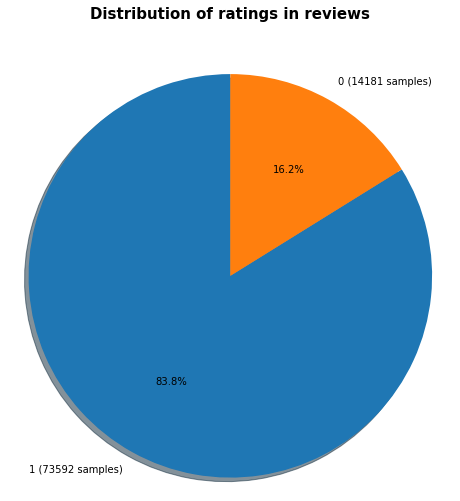

In [129]:
from matplotlib import pyplot as plt
import numpy as np

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({final["Score"].value_counts()[k]} samples)' for k in final['Score'].value_counts().keys()]
sizes = dict(final['Score'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of ratings in reviews",pad=40, fontweight='bold', fontsize=15)
plt.show();

Observation: We see an imbalanced data. The number of postive reviews are 84 percent whereas number of negative reviews are 16 percent.

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [130]:
import random
sent=random.sample(range(1000, 19000), 10)
for i in sent:
    print(final['Text'].values[i])
    print(i)
    print("="*50)

I'd not heard of Orangina until recently.  I found it a refreshing drink, although, a bit pricey making it a nice treat but probably not an every day event.
1463
Very delicious and lightly salted. Packaged well for shipping and arrived in good shape. My shipment has a freshness date of about 20 months or more on the bottom of the container. Fresh.. delicious.. Very happy with this product.
16508
I find it kind of funny how some people found this too salty.  I had to add more salt because to be it wasn't salty enough!  I made some nachos with this and they turned out great.  Most likely someone who didn't know this wasn't real meat wouldn't be able to tell the difference.  I made some enhancements for my tastes, by adding some extra salt, garlic powder, onion bits, and substituting some of the oil it calls for with sharp cheddar, which melts right into at and gives it a little tang and richness.  I bought 3 of these on special at the local grocery store, hoping I wasn't making a mistake

In [131]:
with_tag=final['Text'].values[14668]

In [132]:
pattern=re.compile(r"http\S+")
matches=pattern.finditer(with_tag)
for match in matches:
    print(match)

In [133]:
#How to remove html tag
with_tag=re.sub(r"http\S+","",with_tag)
br_tag=final['Text'].values[3121]
print(br_tag)

Freeze dried liver has a hypnotic effect on dogs. They LOVE it and will do just about anything for it, so it is a great treat to use for training. (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency. It comes chopped/cubed. It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it. The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for large dogs.<br /><br />The largest package sizes of liver treats tend to be far more economical. I recommend buying the larger tubs, as you will save lots of money, you'll have a handy treat supply around for a longer time, and your dog will n

In [134]:
pip install bs4

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Sumit' is not recognized as an internal or external command,
operable program or batch file.


In [135]:
pip install html5lib

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Sumit' is not recognized as an internal or external command,
operable program or batch file.


In [136]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Sumit' is not recognized as an internal or external command,
operable program or batch file.


In [137]:
from bs4 import BeautifulSoup
br_tag=final['Text'].values[3121]
soup=BeautifulSoup(br_tag,"html.parser")
text=soup.get_text()
print(text)
print(br_tag)
print("="*50)

Freeze dried liver has a hypnotic effect on dogs. They LOVE it and will do just about anything for it, so it is a great treat to use for training. (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency. It comes chopped/cubed. It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).Even though your dog will love liver treats, you shouldn't overfeed it. The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for large dogs.The largest package sizes of liver treats tend to be far more economical. I recommend buying the larger tubs, as you will save lots of money, you'll have a handy treat supply around for a longer time, and your dog will never tire of this product.There is r

###### Moving forward I will remove all the contraction of the words like won't-->will not

In [138]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
#Checkout 16913

In [139]:
contracted=final['Text'].values[16913]
print(contracted)
print("="*50)
de_contracted=decontracted(contracted)
print(de_contracted)

<a href="http://www.amazon.com/gp/product/B000H2291O">Barry's Tea Gold Blend, 80-Tea Bag Boxes (Pack of 6)</a><br /><br />  The retail size boxes (I.E. individual 80 bag boxes) were shop worn. Simi-crushed, worn on edges. The experation date was 01/08 (in October),<br />  Amazon immeadiatly gave a refund but in Florida Barry's tea is not to be found.
<a href="http://www.amazon.com/gp/product/B000H2291O">Barry is Tea Gold Blend, 80-Tea Bag Boxes (Pack of 6)</a><br /><br />  The retail size boxes (I.E. individual 80 bag boxes) were shop worn. Simi-crushed, worn on edges. The experation date was 01/08 (in October),<br />  Amazon immeadiatly gave a refund but in Florida Barry is tea is not to be found.


In [140]:
new_text=final['Text'].values[16913]
mera_text=new_text + str("M380 300")

In [141]:
mera_text_now=re.sub(r"\S*\d\S*","",mera_text).strip()
print(mera_text)
print(mera_text_now)

<a href="http://www.amazon.com/gp/product/B000H2291O">Barry's Tea Gold Blend, 80-Tea Bag Boxes (Pack of 6)</a><br /><br />  The retail size boxes (I.E. individual 80 bag boxes) were shop worn. Simi-crushed, worn on edges. The experation date was 01/08 (in October),<br />  Amazon immeadiatly gave a refund but in Florida Barry's tea is not to be found.M380 300
<a  Tea Gold Blend,  Bag Boxes (Pack of  /><br />  The retail size boxes (I.E. individual  bag boxes) were shop worn. Simi-crushed, worn on edges. The experation date was  (in October),<br />  Amazon immeadiatly gave a refund but in Florida Barry's tea is not to be


In [142]:
#Remove allt the special characters
mera_text_now=re.sub("[^a-zA-Z0-9]+",' ',br_tag)
print(mera_text_now)

Freeze dried liver has a hypnotic effect on dogs They LOVE it and will do just about anything for it so it is a great treat to use for training Powdered freeze dried liver is even added to many dog medicines nowadays heartworm and arthritis tablets etc because it causes the dog to scarf the medicine down like a treat br br Freeze dried liver has a dry hard yet powdery easy to chew consistency It comes chopped cubed It is extremely lightweight due to the fact there is so little moisture in the product thus the low weights on product labels br br Even though your dog will love liver treats you shouldn t overfeed it The manufacturer recommends 1 2 cubes daily for small dogs 2 3 cubes for medium dogs and 3 4 cubes for large dogs br br The largest package sizes of liver treats tend to be far more economical I recommend buying the larger tubs as you will save lots of money you ll have a handy treat supply around for a longer time and your dog will never tire of this product br br There is re

In [143]:
#We are removing the words from the stop words list such as 'no', 'nor', 'not' and also we are including br stop words in our stopwoprds

In [144]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [145]:
print(mera_text_now.split())

['Freeze', 'dried', 'liver', 'has', 'a', 'hypnotic', 'effect', 'on', 'dogs', 'They', 'LOVE', 'it', 'and', 'will', 'do', 'just', 'about', 'anything', 'for', 'it', 'so', 'it', 'is', 'a', 'great', 'treat', 'to', 'use', 'for', 'training', 'Powdered', 'freeze', 'dried', 'liver', 'is', 'even', 'added', 'to', 'many', 'dog', 'medicines', 'nowadays', 'heartworm', 'and', 'arthritis', 'tablets', 'etc', 'because', 'it', 'causes', 'the', 'dog', 'to', 'scarf', 'the', 'medicine', 'down', 'like', 'a', 'treat', 'br', 'br', 'Freeze', 'dried', 'liver', 'has', 'a', 'dry', 'hard', 'yet', 'powdery', 'easy', 'to', 'chew', 'consistency', 'It', 'comes', 'chopped', 'cubed', 'It', 'is', 'extremely', 'lightweight', 'due', 'to', 'the', 'fact', 'there', 'is', 'so', 'little', 'moisture', 'in', 'the', 'product', 'thus', 'the', 'low', 'weights', 'on', 'product', 'labels', 'br', 'br', 'Even', 'though', 'your', 'dog', 'will', 'love', 'liver', 'treats', 'you', 'shouldn', 't', 'overfeed', 'it', 'The', 'manufacturer', 'rec

In [146]:
mera_naya_text=' '.join(mera_text_now.split())

In [147]:
print(mera_naya_text)

Freeze dried liver has a hypnotic effect on dogs They LOVE it and will do just about anything for it so it is a great treat to use for training Powdered freeze dried liver is even added to many dog medicines nowadays heartworm and arthritis tablets etc because it causes the dog to scarf the medicine down like a treat br br Freeze dried liver has a dry hard yet powdery easy to chew consistency It comes chopped cubed It is extremely lightweight due to the fact there is so little moisture in the product thus the low weights on product labels br br Even though your dog will love liver treats you shouldn t overfeed it The manufacturer recommends 1 2 cubes daily for small dogs 2 3 cubes for medium dogs and 3 4 cubes for large dogs br br The largest package sizes of liver treats tend to be far more economical I recommend buying the larger tubs as you will save lots of money you ll have a handy treat supply around for a longer time and your dog will never tire of this product br br There is re

### [3.1] Preprocessing Text variable 

In [148]:
#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
#Combining all the above Stundents
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from tqdm import tqdm
preprocessed_reviews=[]
#tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance=re.sub(r"http\S+","",sentance)
    sentance=BeautifulSoup(sentance,'html.parser').get_text()
    sentance=decontracted(sentance)
    sentance=re.sub("\S*\d\S*","",sentance).strip()
    sentance=re.sub('[^A-Za-z]+',' ',sentance)
    sentance=' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sentance=' '.join(token.lemma_ for token in nlp(sentance) if token not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [07:38<00:00, 191.30it/s]


### [3.2] Preprocessing Summary variable 

In [149]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

preprocessed_summary=[]
for sentance in tqdm(final['Summary'].values):
    sentance=re.sub(r"http\S+","",sentance)
    sentance=BeautifulSoup(sentance,'html.parser').get_text()
    sentance=decontracted(sentance)
    sentance=re.sub("\S*\d\S*","",sentance).strip()
    sentance=re.sub('[^A-Za-z]+',' ',sentance)
    sentance=' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sentance=' '.join(token.lemma_ for token in nlp(sentance) if token not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [04:26<00:00, 328.77it/s]


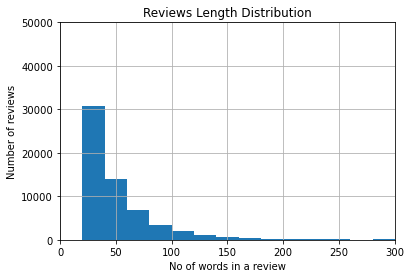

In [150]:
bins = [20*i for i in range(1, 30)]

plt.hist([len(s.split()) for s in preprocessed_reviews], bins=bins)
# sns.displot([len(s.split()) for s in preprocessed_reviews])
plt.xlabel('No of words in a review')
plt.ylabel('Number of reviews')
plt.title('Reviews Length Distribution') 

plt.axis([0, 300, 0,50000])
plt.grid(True)

plt.show()

In [151]:
# Median number of words in a review

average_number_of_words=np.median([len(s.split()) for s in preprocessed_reviews])
print('average number of words in a review are:',average_number_of_words)

average number of words in a review are: 28.0


#### Observation: The number of words follow a right skewed distribution and the average number of words in a review is 28.

#### Now we will merge both Summary and Text as they both include important information about the sentiment of the review.

In [152]:
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_reviews=list(map(concatenateSummaryWithText,preprocessed_reviews,preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

In [153]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs love chicken product china will not buy a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love see pet store tag attach regard make...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflie literally everywhere fly...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,bad product get long time would rate no star c...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read review make purchase basically...


##### Obtaining independent variable/variables and target variable. Here we will use preprocessed data 

In [154]:
X = final['CleanedText']
y = final['Score']

In [155]:
del final
del preprocessed_reviews
del preprocessed_summary
del sorted_data
del filtered_data

### Splitting the data

In [156]:
from sklearn.model_selection import train_test_split
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Train data:", X_train.shape)

print("Shape of CV data   :", X_cv.shape)

print("Shape of Test data :", X_test.shape)


Shape of Input  - Train: (56174,)
Shape of Output - Train: (56174,)
Shape of Input  - CV   : (14044,)
Shape of Output - CV   : (14044,)
Shape of Input  - Test : (17555,)
Shape of Output - Test : (17555,)


In [157]:
type(X_train)

pandas.core.series.Series

### Encoding the data using tfidf weighted word2vec

#### Step 1: Build your own Word2Vec Model

In [158]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [159]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=2)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('excellent', 0.8102672100067139), ('good', 0.7786469459533691), ('awesome', 0.774895191192627), ('fantastic', 0.7705259323120117), ('perfect', 0.7262156009674072), ('terrific', 0.6975555419921875), ('wonderful', 0.6698840856552124), ('nice', 0.6698441505432129), ('fabulous', 0.6330946683883667), ('decent', 0.6027126908302307)]
[('surpass', 0.7195035219192505), ('baklava', 0.7086992263793945), ('tastiest', 0.7009731531143188), ('best', 0.697618842124939), ('freshest', 0.6891564130783081), ('nutricity', 0.6695865392684937), ('bumblebee', 0.6647889614105225), ('irresistable', 0.6552206873893738), ('pleasent', 0.6493546366691589), ('crunchiest', 0.6407248377799988)]


In [160]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12196
sample words  ['yes', 'gracie', 'really', 'rush', 'living', 'room', 'enjoy', 'one', 'treat', 'peace', 'time', 'think', 'something', 'special', 'big', 'enough', 'break', 'two', 'piece', 'mini', 'dachshund', 'eat', 'candy', 'know', 'full', 'healthy', 'organic', 'ingredient', 'happy', 'highly', 'recommended', 'hurry', 'buy', 'case', 'since', 'come', 'market', 'variety', 'subscribe', 'save', 'order', 'large', 'quantity', 'frequently', 'get', 'sell', 'well', 'extra', 'explain', 'three']


In [161]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [162]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

#### Step 2: Fitting tfidf model on our train data

In [163]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#### Step 3: Obtaining tfidf weighted word2vec on train,cv and test data

In [164]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_weighted_train=tfidf_sent_vectors_train

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [28:58<00:00, 32.31it/s]


In [165]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_weighted_cv=tfidf_sent_vectors_cv

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [07:12<00:00, 32.51it/s]


In [166]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_weighted_test=tfidf_sent_vectors_test

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [11:05<00:00, 26.39it/s]


### [4] Training and Testing the model using LogisticRegression

In [167]:
from sklearn.metrics import roc_curve, auc


In [172]:
import math

alpha=[10**x for x in range(-6,3)]
train_auc=[]
cv_auc=[]
log_alpha=[]
for i in alpha:
    print("for alpha =", i)
    clf=SGDClassifier(class_weight='balanced',alpha=i,penalty='l2',loss='log',random_state=42)
    clf.fit(tfidf_weighted_train,y_train)

    sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(tfidf_weighted_train,y_train)
    log_alpha.append(math.log10(i))
    y_train_pred=sig_clf.predict_proba(tfidf_weighted_train)[:,1]
    y_cv_pred=sig_clf.predict_proba(tfidf_weighted_cv)[:,1]

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    print("AUC score for validation data is:",(roc_auc_score(y_cv,y_cv_pred)))



# new_alpha=t[best_alpha]
# print("Best alpha when we use tfidf features is:",new_alpha)
# print(log_alpha)
# plt.plot(log_alpha, train_auc, label="Train AUC")
# plt.plot(log_alpha, cv_auc, label="CV AUC")
# plt.scatter(log_alpha, train_auc, label="Train AUC points")
# plt.scatter(log_alpha, cv_auc, label="CV AUC points")
# plt.legend()
# plt.xlabel("log(alpha): hyperparameter")
# plt.ylabel("AUC")
# plt.title("ERROR PLOTS")
# plt.grid()
# plt.show()

for alpha = 1e-06
AUC score for validation data is: 0.9011500151118322
for alpha = 1e-05
AUC score for validation data is: 0.8994982871697268
for alpha = 0.0001
AUC score for validation data is: 0.9014431191570311
for alpha = 0.001
AUC score for validation data is: 0.901930028941732
for alpha = 0.01
AUC score for validation data is: 0.8984792911755322
for alpha = 0.1
AUC score for validation data is: 0.8878404864232118
for alpha = 1
AUC score for validation data is: 0.8723620776289676
for alpha = 10
AUC score for validation data is: 0.8641584580878245
for alpha = 100
AUC score for validation data is: 0.8637803909239177


Best alpha when we use tfidf features is: 0.001
[-6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0]


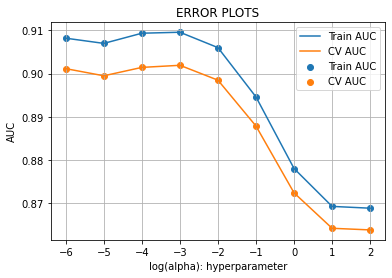

In [178]:
best_alpha=np.argmax(cv_auc)
new_alpha=alpha[best_alpha]
print("Best alpha when we use tfidf features is:",new_alpha)
print(log_alpha)

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC')
plt.scatter(log_alpha, cv_auc, label='CV AUC')

plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


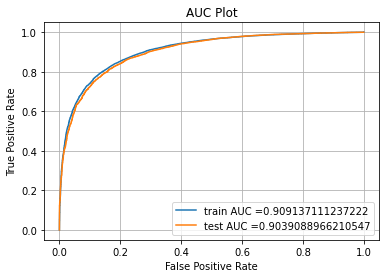

In [184]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc


clf = SGDClassifier(class_weight='balanced',alpha=new_alpha,penalty='l2',loss='log',random_state=42)
clf.fit(tfidf_weighted_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = clf.predict_proba(tfidf_weighted_train)[:,1]    
y_test_pred = clf.predict_proba(tfidf_weighted_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Plot")
plt.grid()
plt.show()

## Random Forest

for n_estimators = 100 and max depth =  5
AUC score is: 0.8560898438194479
for n_estimators = 100 and max depth =  10
AUC score is: 0.8851575233063753
for n_estimators = 200 and max depth =  5
AUC score is: 0.8562172510688228
for n_estimators = 200 and max depth =  10
AUC score is: 0.8859832749913679
for n_estimators = 500 and max depth =  5
AUC score is: 0.8555418878468118
for n_estimators = 500 and max depth =  10
AUC score is: 0.8860403537385176
for n_estimators = 1000 and max depth =  5
AUC score is: 0.8559525179681089
for n_estimators = 1000 and max depth =  10
AUC score is: 0.886306247128518
for n_estimators = 2000 and max depth =  5
AUC score is: 0.8557355438715673
for n_estimators = 2000 and max depth =  10
AUC score is: 0.8863232397522595


NameError: name 'cv_log_error_array' is not defined

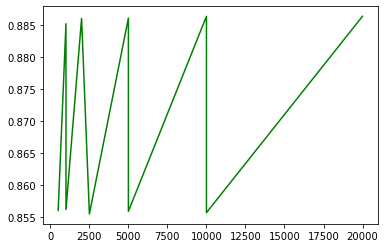

In [185]:
from sklearn.ensemble import RandomForestClassifier
import math as mt

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_auc=[]

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(tfidf_weighted_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(tfidf_weighted_train,y_train)
        log_alpha.append(mt.log10(i))
    
        y_train_pred=sig_clf.predict_proba(tfidf_weighted_train)[:,1]
        y_cv_pred=sig_clf.predict_proba(tfidf_weighted_cv)[:,1]
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
        print('AUC score is:',roc_auc_score(y_cv,y_cv_pred))

#Since here we have combination of features. In order to obtain the right 
#combination we are first multiplying the two hyperparameters and after obtaining the right index, we will divide it by 2. Becuase for every hyperparameter their exist two combinations.



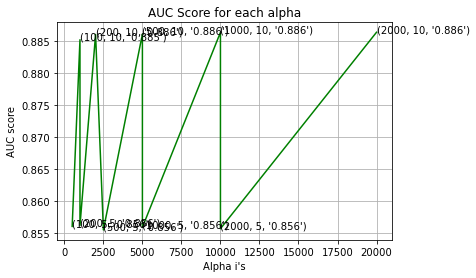

In [187]:
#Plotting cv_auc against features
fig,ax=plt.subplots()
features=np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features,cv_auc,c='g')


for i, txt in enumerate(np.round(cv_auc,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_auc[i]))

plt.grid()
plt.title("AUC Score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("AUC score")
plt.show()

### Finiding the best Hyperparameter

In [188]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
combinations=[]
def hyp_combination(parm1,parm2):
    for i in parm1:
        for j in parm2:
            combinations.append((i,j))
    return combinations

best_alpha_index=np.argmax(cv_auc)
new_alpha=hyp_combination(max_depth,alpha)[best_alpha]
print(new_alpha)

(5, 1000)


### Training our model on best hyperparameter

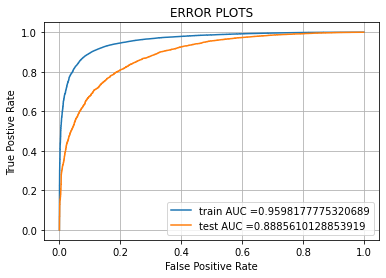

In [189]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10, random_state=42, n_jobs=-1)
clf.fit(tfidf_weighted_train, y_train)

sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(tfidf_weighted_train,y_train)

y_train_pred=sig_clf.predict_proba(tfidf_weighted_train)[:,1]
y_test_pred=sig_clf.predict_proba(tfidf_weighted_test)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Postive Rate")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Tokenizing the dataset

In [ ]:
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

### Padding the dataset

This is just to give batch input to the RNN

In [ ]:
# truncate or pad input sequence

max_review_length=1000
X_train_new=sequence.pad_sequences(X_train_new,maxlen=max_review_length)
X_cv_new=sequence.pad_sequences(X_cv_new,maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

In [ ]:
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 5
batchsize = 512

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

### Model M1 ( Embedding -> LSTM -> Output(Sigmoid) ) 

In [ ]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC()])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())
print("***********************************************")

In [ ]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

In [ ]:
final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["accuracy"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)